In [1]:
import random
import numpy as np

import torch
from torch.utils.data import SequentialSampler, BatchSampler, DataLoader

import datasets.transforms as T
from datasets.coco import CocoDetection, collate_fn
from models.backbone import ResNetBackbone
from models.transformer import TransformerBitLinear
from models.detr import DETR, SetCriterion
from models.matcher import HungarianMatcher
from util.misc import rescale_bboxes, plot_results

In [2]:
# keep random seed fixed to keep my sanity
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

class Args:
  coco_path = "/workspace/coco"
  dataset_file = "coco"
  masks = False
args = Args()

In [3]:

scales = [480, 512, 544, 576, 608, 640, 672, 704, 736, 768, 800]
transform_train = T.Compose([
  # augumentation
  T.RandomHorizontalFlip(),
  T.RandomSelect(
    T.RandomResize(scales, max_size=1333),
    T.Compose([
      T.RandomResize([400, 500, 600]),
      T.RandomSizeCrop(384, 600),
      T.RandomResize(scales, max_size=1333),
    ])
  ),
  # normalize
  T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])
])     

In [4]:
dataset = CocoDetection("/workspace/coco/train2017", "/workspace/coco/annotations/instances_train2017.json", transform_train, return_masks=False)
sampler_train = SequentialSampler(dataset)
batch_sampler_train = BatchSampler(sampler_train, batch_size=8, drop_last=True)
data_loader_train = DataLoader(dataset, batch_sampler=batch_sampler_train, collate_fn=collate_fn, num_workers=1)
batch_fetcher = iter(data_loader_train)

loading annotations into memory...
Done (t=10.01s)
creating index...
index created!


In [5]:
x, x_mask, y = next(batch_fetcher)

## DETR Model

In [6]:
device = "cuda"

backbone = ResNetBackbone()
transformer = TransformerBitLinear(256, 8, 6, 6, 2048, 0.1)
model = DETR(backbone, transformer, num_classes=91, num_queries=100).to(device)

matcher = HungarianMatcher()
criterion = SetCriterion(91, matcher).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler()

In [7]:
model = model.train()
x, x_mask = x.to(device), x_mask.to(device) 
y = [{k: v.to(device) for k, v in t.items()} for t in y]

In [8]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

for epochs in range(500):
  optimizer.zero_grad()
  with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
    outputs_logits, outputs_boxes = model(x, x_mask)
    loss = criterion(outputs_logits, outputs_boxes, y)

  writer.add_scalar("Loss/train", loss, epochs)
 
  scaler.scale(loss).backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
  scaler.step(optimizer)
  scaler.update()

## Inspect predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


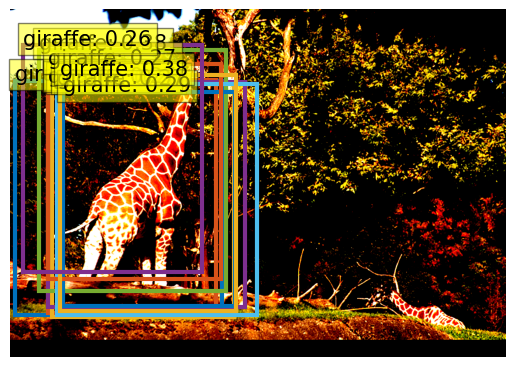

In [18]:
i = 1
with torch.no_grad():
  h, w = y[i]["size"]
  im = x[i].cpu().numpy().transpose((1,2,0))
  prob = outputs_logits[i,:].softmax(-1)[:, :-1]
  keep = prob.max(-1).values > 0.25
  plot_results(im, prob[keep], rescale_bboxes(outputs_boxes[i][keep,:], (w,h)))

## Inspect ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


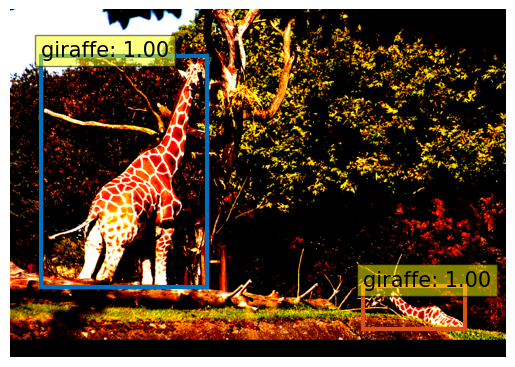

In [19]:
i = 1
h, w = y[i]["size"]
im = x[i].cpu().numpy().transpose((1,2,0))
prob = torch.zeros((len(y[i]["labels"]), 91))
prob[torch.arange(len(y[i]["labels"])), y[i]["labels"].cpu()] = 1
plot_results(im, prob, rescale_bboxes(y[i]["boxes"], (w,h)))